In [ ]:
!pip install langchain_community langchain_core langgraph langchain_openai langchain_groq ddgs yfinance

In [ ]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [ ]:
llm_openai_model = ChatOpenAI(model = 'gpt-3.5-turbo')
llm_groq_model = ChatGroq(model = 'Gemma2-9b-It')

In [ ]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
@tool
def add(a: float, b: float) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b
@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [ ]:
search_tool = DuckDuckGoSearchRun()

In [ ]:
tools = [search_tool,divide,add,multiply]

In [ ]:
tool_node = ToolNode(tools)

In [ ]:
llm_with_tool = llm_openai_model.bind_tools(tools)

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")


In [ ]:
def reasoner (state : MessagesState) :
  return {'messages' : [llm_with_tool.invoke([sys_msg] + state['messages'])]}

In [ ]:
graph = StateGraph(MessagesState)

In [ ]:
graph.add_node('reasoner' , reasoner)
graph.add_node('tools' , tool_node)

graph.add_edge(START , "reasoner")

graph.add_conditional_edges("reasoner" , tools_condition ,)
graph.add_edge("tools" , "reasoner")

In [ ]:
workflow = graph.compile()

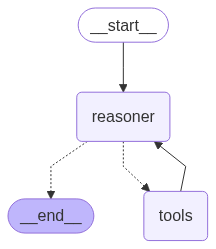

In [ ]:
display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content = "What is the age of the current prime minister of pakistan")]

In [ ]:
messages = workflow.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the age of the current prime minister of pakistan
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_fX93FnAUU1pO5xbXu5Ljjizy)
 Call ID: call_fX93FnAUU1pO5xbXu5Ljjizy
  Args:
    query: current prime minister of Pakistan
================================= Tool Message =================================
Name: duckduckgo_search

Mian Muhammad Shehbaz Sharif[a] (born 23 September 1951) is a Pakistani politician and businessman who has served as the 20th prime minister of Pakistan since March 2024, having previously been in the role between April 2022 to August 2023. The prime minister of Pakistan is the head of the Government of Pakistan . The prime minister is vested with the responsibility of running the administration through his appointed federal cabinet, formulating national and foreign policies to ensure th... Mar 3, 2024 · Pakis

# Building a stock price bot

In [ ]:
class StockState (TypedDict) :
  query : str
  final_answer : str
  messages : Annotated[list[AnyMessage] , add_messages]

In [ ]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [ ]:
tools = [add, multiply, divide,  get_stock_price , search_tool]

In [ ]:
llm_with_tools = llm_openai_model.bind_tools(tools)

In [ ]:
tool_node = ToolNode(tools)

In [ ]:
def reasoner (state) :
  messages = state['messages']
  sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
  result = llm_with_tools.invoke([sys_msg] + messages)
  return {'messages' : [result]}


In [ ]:
graph_1 = StateGraph(StockState)

In [ ]:
graph_1.add_node('reasoner' , reasoner)
graph_1.add_node('tools', tool_node)

graph_1.add_edge(START , "reasoner")

graph_1.add_conditional_edges("reasoner" , tools_condition ,)
graph_1.add_edge("tools" , "reasoner")

In [ ]:
workflow_1 = graph_1.compile()

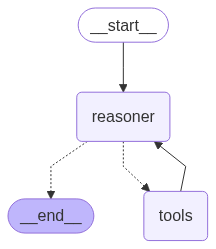

In [ ]:
display(Image(workflow_1.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = workflow_1.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})


In [ ]:
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_gFlKs3AzJ3bD1hHlKK0NkW2V)
 Call ID: call_gFlKs3AzJ3bD1hHlKK0NkW2V
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

232.56
================================== Ai Message ==================================

The current stock price of Apple (AAPL) is $232.56.
